# fig — emnist to imgnet

**Motivation**: host = ```mach```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def _process_cifar(dl):
    x_down = []
    for x, *_ in iter(dl):
        x_down.append(F.interpolate(
            input=x,
            size=(28, 28),
            mode='bilinear',
            antialias=True,
        ))
    x_down = torch.cat(x_down)
    x_down = (1 + x_down) / 2
    x_down *= mask_mnist

    kws_dataloader = dict(
        batch_size=2000,
        drop_last=False,
        shuffle=False,
    )
    ds_down = torch.utils.data.TensorDataset(
        x_down, dl.dataset.tensors[1])
    dl_down = torch.utils.data.DataLoader(
        ds_down, **kws_dataloader)
    return dl_down


def rgb_to_grayscale(image):
    # Coefficients for converting RGB to grayscale
    r, g, b = image[:, 0, :, :], image[:, 1, :, :], image[:, 2, :, :]
    gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray_image.unsqueeze(1)  # Add back the channel dimension


def _process_imgnet(dl):
    x, g = dl.dataset.tensors
    
    x = rgb_to_grayscale(x)
    x_down = F.interpolate(
        input=x,
        size=(28, 28),
        mode='bilinear',
        antialias=True,
    )
    x_down = (1 + x_down) / 2
    x_down *= mask_mnist.to(x_down.device)

    kws_dataloader = dict(
        batch_size=1500,
        drop_last=False,
        shuffle=False,
    )
    ds_down = torch.utils.data.TensorDataset(x_down, g)
    dl_down = torch.utils.data.DataLoader(ds_down, **kws_dataloader)
    return dl_down

In [3]:
from analysis.chosen import *
from figures.analysis import *
from analysis.final import save_both_row_col

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: mach

In [4]:
fig_dir = pjoin(fig_base_dir, 'iclr_oct02', 'recon')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

['recon_src-MNIST_tgt-MNIST', 'recon_src-MNIST_tgt-Omniglot']

## iP-VAE

In [5]:
models_to_load = selected_models_28x28(device, full=True)

_PVAE_MODELS = [
    # 'MNIST_<jacob|mlp>_(64,24.0)',
    # 'MNIST_<jacob|conv>_(16,8.0)',
    #'Omniglot_<jacob|mlp>_(64,24.0)',
    # 'Omniglot_<jacob|conv>_(16,8.0)',
    'EMNIST_<jacob|mlp>_(64,24.0)',
]
models_to_load = {
    m: d for m, d in
    models_to_load.items()
    if m in _PVAE_MODELS
}
models_to_load = dict(sorted(
    models_to_load.items(),
    key=lambda t: alphanum_sort_key(t[0]),
))
print(list(models_to_load))

['EMNIST_<jacob|mlp>_(64,24.0)']

In [6]:
trainers = {}
for name, kwargs in tqdm(models_to_load.items()):
    tr = load_model(**kwargs)[0]
    tr.cfg.batch_size = 2000
    trainers[name] = tr

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


In [7]:
tr = trainers['EMNIST_<jacob|mlp>_(64,24.0)']
var_mnist = torch.var(tr.dl_trn.dataset.tensors[0], dim=0, keepdim=True)
mask_mnist = var_mnist / torch.max(var_mnist)

var_mnist.shape

torch.Size([1, 1, 28, 28])

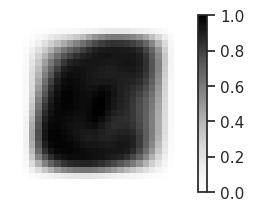

In [8]:
fig, ax = create_figure()
im = ax.imshow(tonp(mask_mnist.squeeze()), cmap='Greys')
plt.colorbar(im, ax=ax)
remove_ticks(ax)
plt.show()

In [10]:
# mask_mnist = mask_mnist > 0.05

# plt.imshow(tonp(mask_mnist.squeeze()))
# plt.colorbar()
# plt.show()

## ImgNet32 downsample

In [9]:
%%time

from base.dataset import make_dataloader

# trn, vld = make_dataloader('ImageNet32', 'cpu', grey=True, skip_trn=False)
# trn, vld = map(_process_imgnet, [trn, vld])

vld = make_dataloader('ImageNet32', 'cpu', grey=True, skip_trn=True)[1]
vld = _process_imgnet(vld)

CPU times: user 16.6 s, sys: 5.94 s, total: 22.5 s
Wall time: 728 ms


In [10]:
vld.dataset.tensors[0].min(), vld.dataset.tensors[0].max()

(tensor(0.), tensor(1.0000))

In [11]:
tr = trainers['EMNIST_<jacob|mlp>_(64,24.0)']

results = tr.analysis(
    dl=vld,
    seq_total=1_000,
    n_data_batches=4,
    return_recon=True,
    avg_samples=False,
)

100%|███████████████████████████████████| 4/4 [00:45<00:00, 11.34s/it]


In [14]:
results_avg = {k: v.mean(0) if v.ndim == 2 else v for k, v in results.items()}

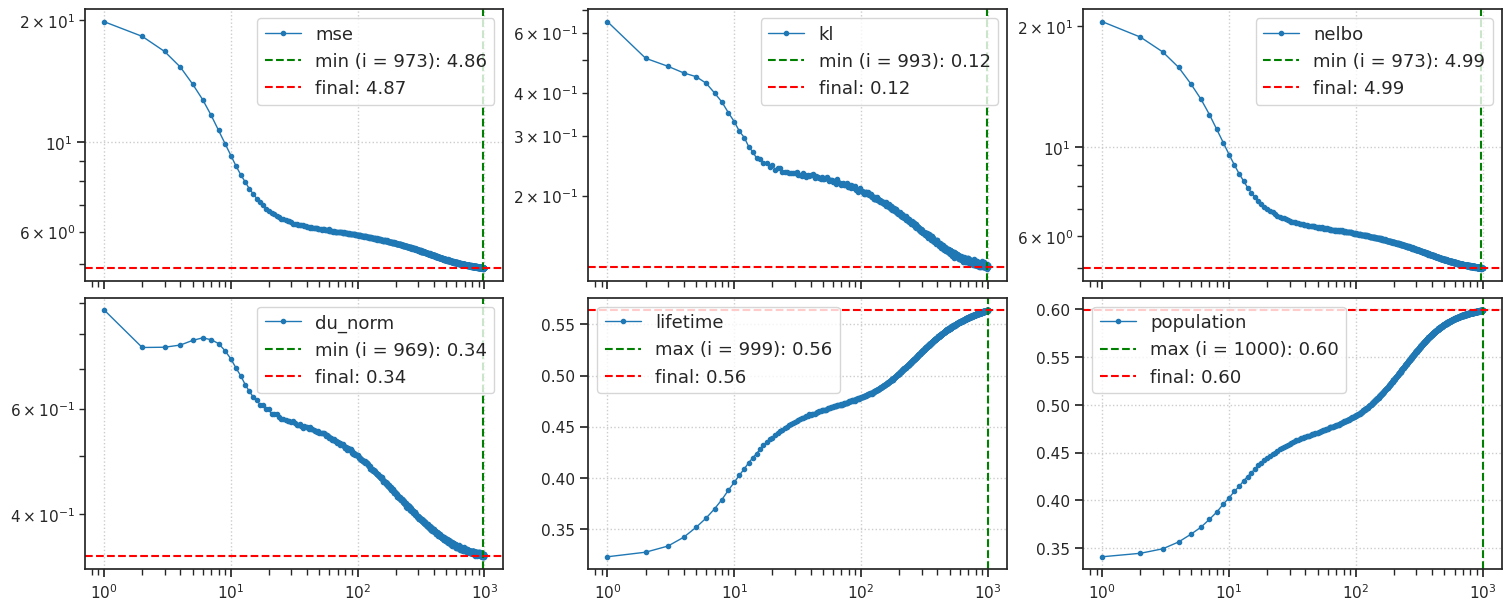

In [15]:
_ = plot_convergence(results_avg)

In [16]:
results['recon'].shape

(8000, 1000, 784)

In [21]:
# save_obj(
#     obj=results['recon'][:, -1],
#     file_name='mnist-to-imgnet_last-time-point',
#     save_dir=tmp_dir,
#     mode='npy',
# )

# save_obj(
#     obj=results['recon'],
#     file_name='mnist-to-imgnet_recon-full',
#     save_dir=tmp_dir,
#     mode='npy',
# )

[PROGRESS] 'mnist-to-imgnet_last-time-point.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

[PROGRESS] 'mnist-to-imgnet_recon-full.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

In [18]:
recon = results['recon'][:, -1]
recon = recon.reshape(tr.model.cfg.shape)
src = vld.dataset.tensors[0][:len(recon)]

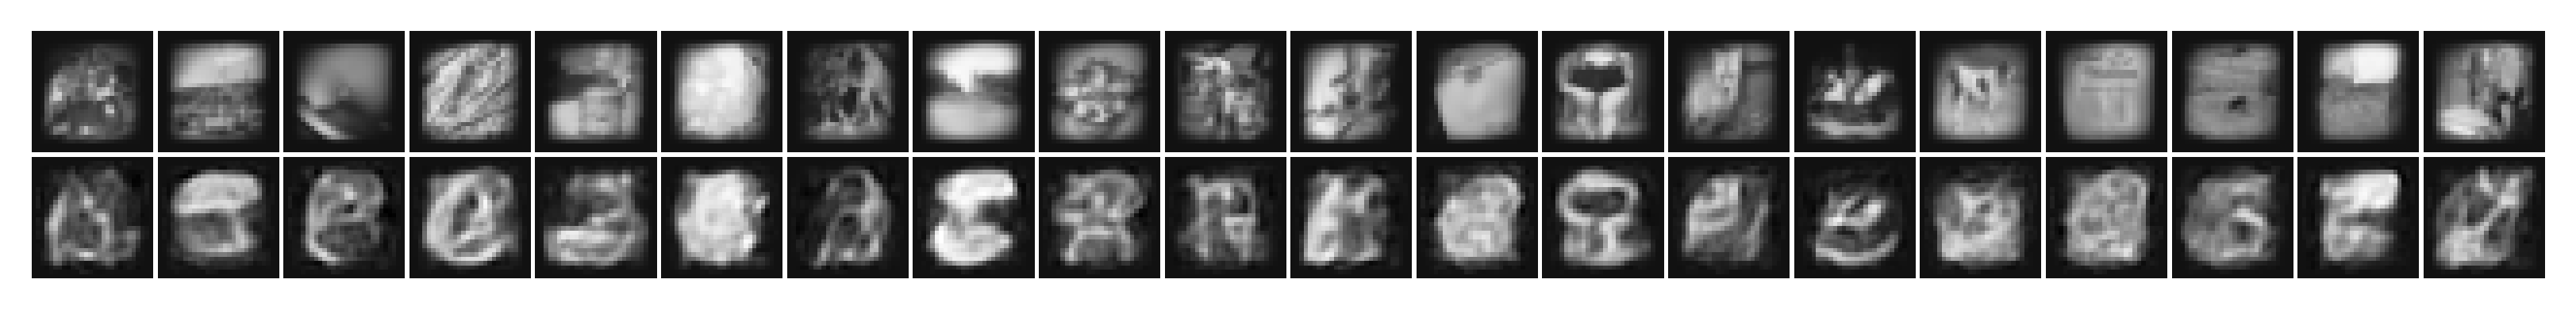

In [19]:
i = 50
intvl = range(i, i + 20)

x2p = np.concatenate([
    tonp(src)[intvl],
    tonp(recon)[intvl],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=400, cmap='Greys_r', vmin=0.0, vmax=1.0)

In [20]:
nmse = (torch.tensor(recon, device=src.device) - src) ** 2
nmse /= torch.var(src, dim=(1, 2, 3), keepdim=True)
nmse = torch.sum(nmse, dim=(1, 2, 3))

In [21]:
order = np.argsort(tonp(nmse))

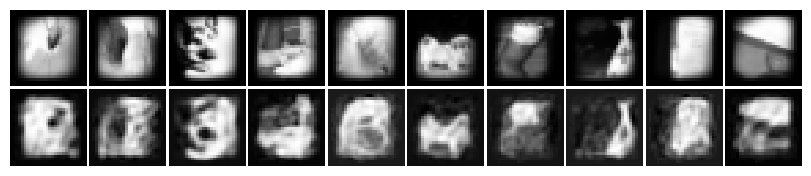

In [22]:
i = 1200
intvl = range(i, i + 10)
intvl = order[intvl]

x2p = np.concatenate([
    tonp(src)[intvl],
    tonp(recon)[intvl],
])
fig, ax = plot_weights(x2p, nrows=2, dpi=100, cmap='Greys_r', vmin=0.0, vmax=1.0)

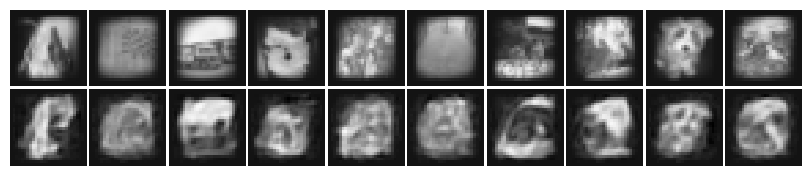

In [23]:
i = 1600
intvl = range(i, i + 10)
intvl = order[intvl]

x2p = np.concatenate([
    tonp(src)[intvl],
    tonp(recon)[intvl],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=100, cmap='Greys_r', vmin=0.0, vmax=1.0)

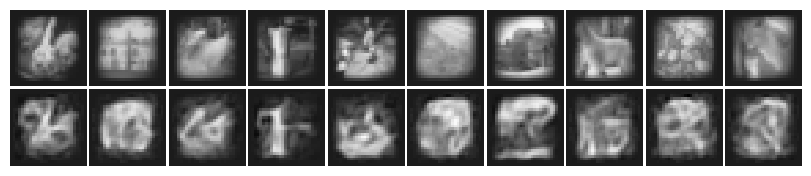

In [24]:
i = 3330
intvl = range(i, i + 10)
intvl = order[intvl]

x2p = np.concatenate([
    tonp(src)[intvl],
    tonp(recon)[intvl],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=100, cmap='Greys_r', vmin=0.0, vmax=1.0)

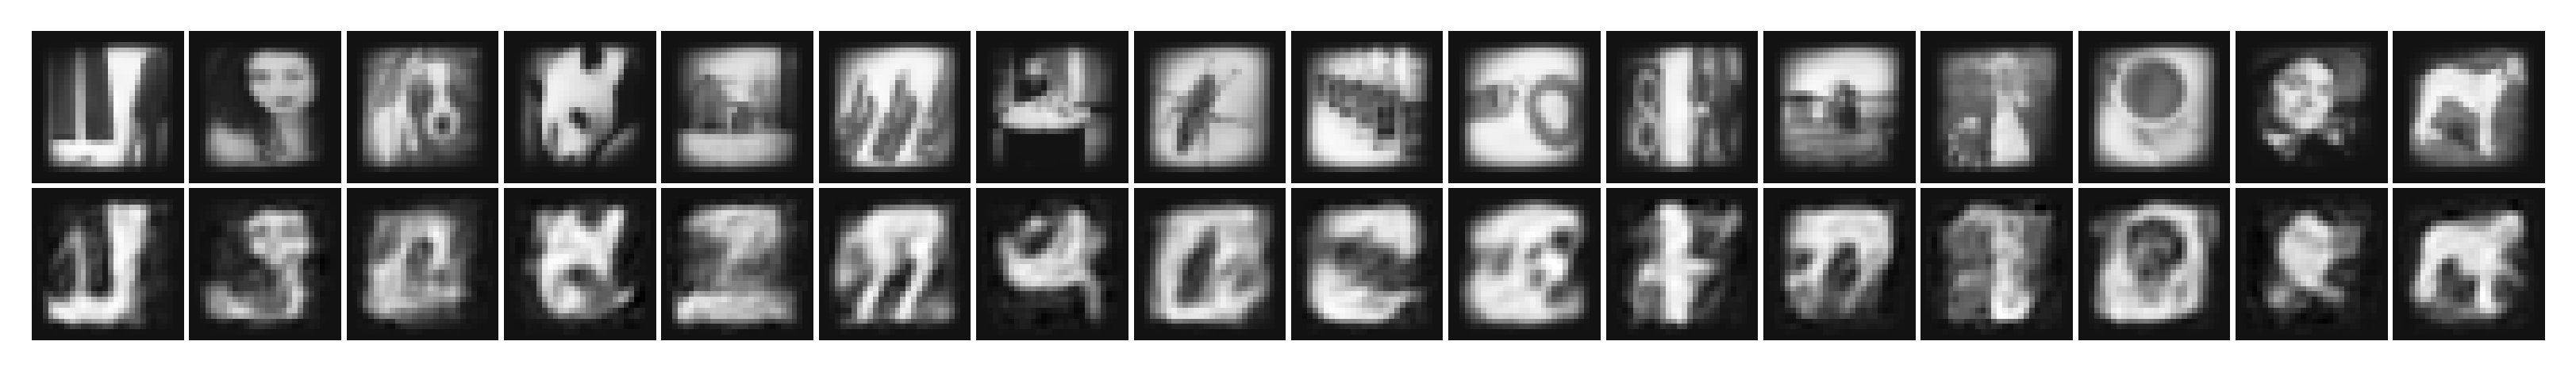

In [26]:
selected_inds = np.array([
    7916, 2146, 5931, 7463, 5540, 2937, 6983, 5313,
    1375, 1712, 3320, 3633, 5818, 6268, 6489, 5598,
])

x2p = np.concatenate([
    tonp(src)[selected_inds],
    tonp(recon)[selected_inds],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=400, cmap='Greys_r', vmin=0.0, vmax=1.0)

In [107]:
selected_inds = [
    1204, 1508, 1744, 1382, 1521, 1527, 1529, 1560, 1584, 1589, 1594,
    1622, 1520, 1906, 1954, 2109, 1016, 1070, 1098, 3241, 3243,
]
selected_inds = order[selected_inds]

selected_inds

array([7916, 2146, 5931, 7463, 5540, 2937, 6983, 5313, 1375, 1712, 3320,
       3633, 5818, 6268, 6489, 5598, 5779, 4809, 2561, 3886, 7511])

In [16]:
selected_inds = np.array([
    7916, 2146, 5931, 7463, 5540, 2937, 6983, 5313,
    1375, 1712, 3320, 3633, 5818, 6268, 6489, 5598,
])
selected_inds

array([7916, 2146, 5931, 7463, 5540, 2937, 6983, 5313, 1375, 1712, 3320,
       3633, 5818, 6268, 6489, 5598])

In [18]:
recon = results['recon'][:, -1]
recon = recon.reshape(tr.model.cfg.shape)
src = vld.dataset.tensors[0][:len(recon)]

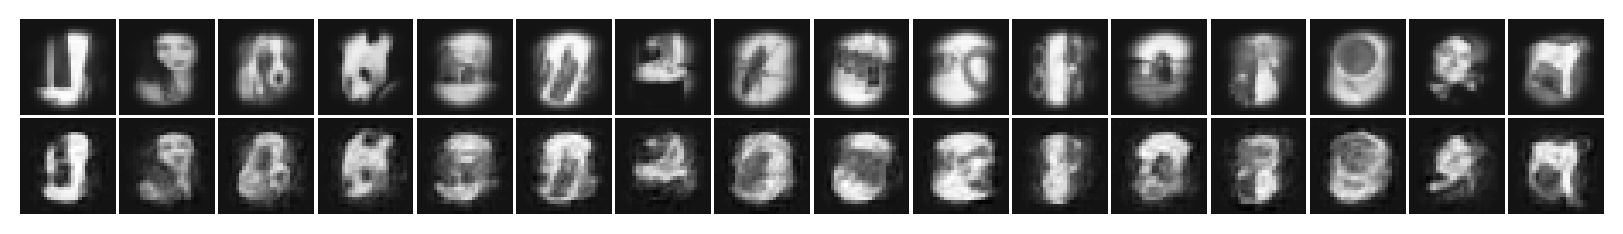

In [19]:
x2p = np.concatenate([
    tonp(src)[selected_inds],
    tonp(recon)[selected_inds],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=200, cmap='Greys_r', vmin=0.0, vmax=1.0)

In [156]:
tr.dl_tst.dataset

In [ ]:
#medium: 4277, 101, 2981, 651, 900, 5176, 678, 1905, 3707, 2422, 3320, 5478, 3954, 5875, 2192
#good: 1652, 3109, 526, 2032, 1763, 4320, 615, 5386, 1484, 3012, 2664, 1825, 1216, 4635, 3369,5347, 534, 4232, 1924, 5381, 200, 5489, 5720, 4238,884 , 1080, 4121, 4086,
#semantic: 1824, 1637, 1174, 2759, 5699, 3021, 134, 1675, 4394, 3473, 1137, 2893, 4928, 5261, 5324, 1943, 1909, 2959, 4336, 692, 1380,a

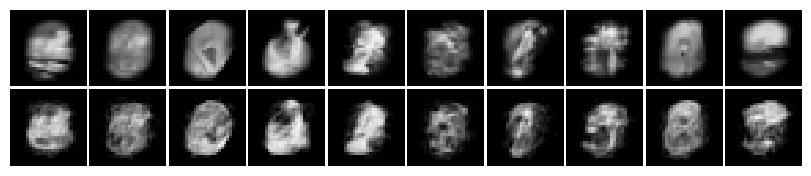

In [43]:
i = 120
intvl = range(i, i + 10)

x2p = np.concatenate([
    tonp(src)[intvl],
    tonp(recon)[intvl],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=100, cmap='Greys_r', vmin=0.05, vmax=1.0)

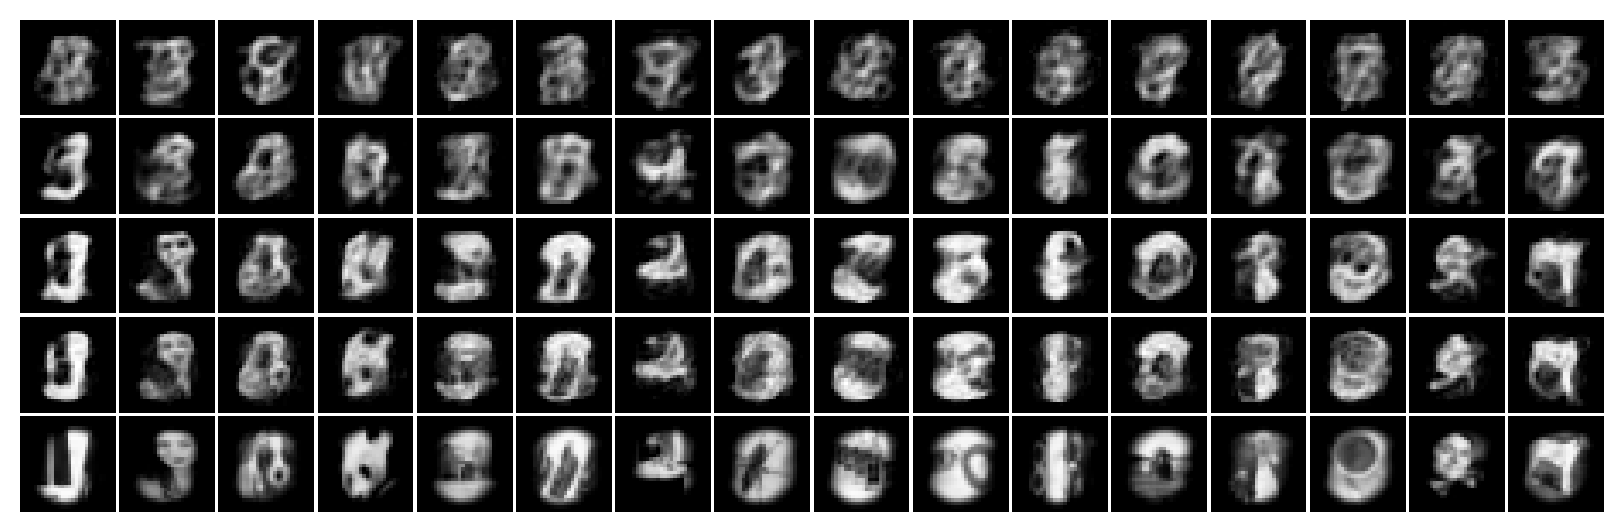

In [26]:
x2p = []
for t in [0, 9, 99, 999]:
    recon = results['recon'][:, t]
    recon = recon.reshape(tr.model.cfg.shape)
    x2p.append(tonp(recon)[selected_inds])
x2p.append(tonp(src)[selected_inds])
x2p = np.concatenate(x2p)

fig, ax = plot_weights(x2p, nrows=5, method='none', dpi=200, cmap='Greys_r', vmin=0.05, vmax=1.0)

In [50]:
mse = results['mse'][:, -1]
vars = tonp(torch.var(src, dim=(1, 2, 3)))

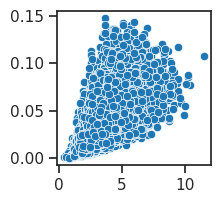

In [51]:
ax = sns.scatterplot(x=mse, y=vars)
ax_square(ax);

In [53]:
# selected = np.where(vars > 0.1)
# order = np.argsort(mse[selected])
order = np.argsort(vars)

In [61]:
len(vars)

50000

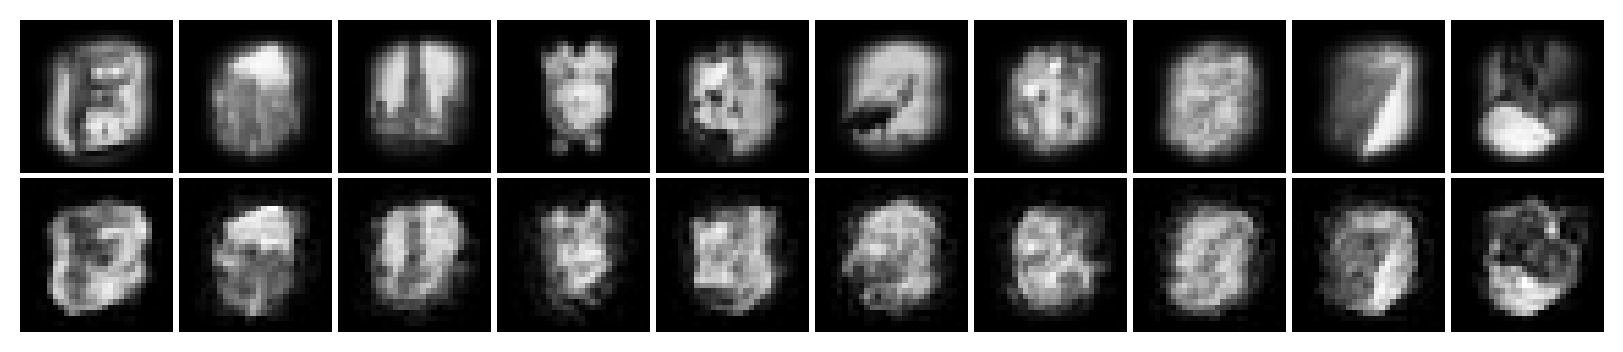

In [64]:
intvl = range(39000, 39010)
x2p = np.concatenate([
    tonp(src)[order][intvl],
    tonp(recon)[order][intvl],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=200, cmap='Greys_r', vmin=0.0001, vmax=None)

## CIFAR downsample

In [12]:
from base.dataset import make_dataloader

trn_cifar, vld_cifar = make_dataloader('CIFAR10', device, grey=True)
trn_cifar, vld_cifar = map(_process_cifar, [trn_cifar, vld_cifar])

In [13]:
tr = trainers['MNIST_<jacob|mlp>_(64,24.0)']

results = tr.analysis(
    dl=vld_cifar,
    seq_total=1_000,
    n_data_batches=5,
    return_recon=True,
    avg_samples=False,
)
recon = results['recon'][:, -1]
recon = recon.reshape(tr.model.cfg.shape)

100%|███████████████████████████████████| 5/5 [00:19<00:00,  3.80s/it]


In [14]:
results_avg = {k: v.mean(0) if v.ndim == 2 else v for k, v in results.items()}

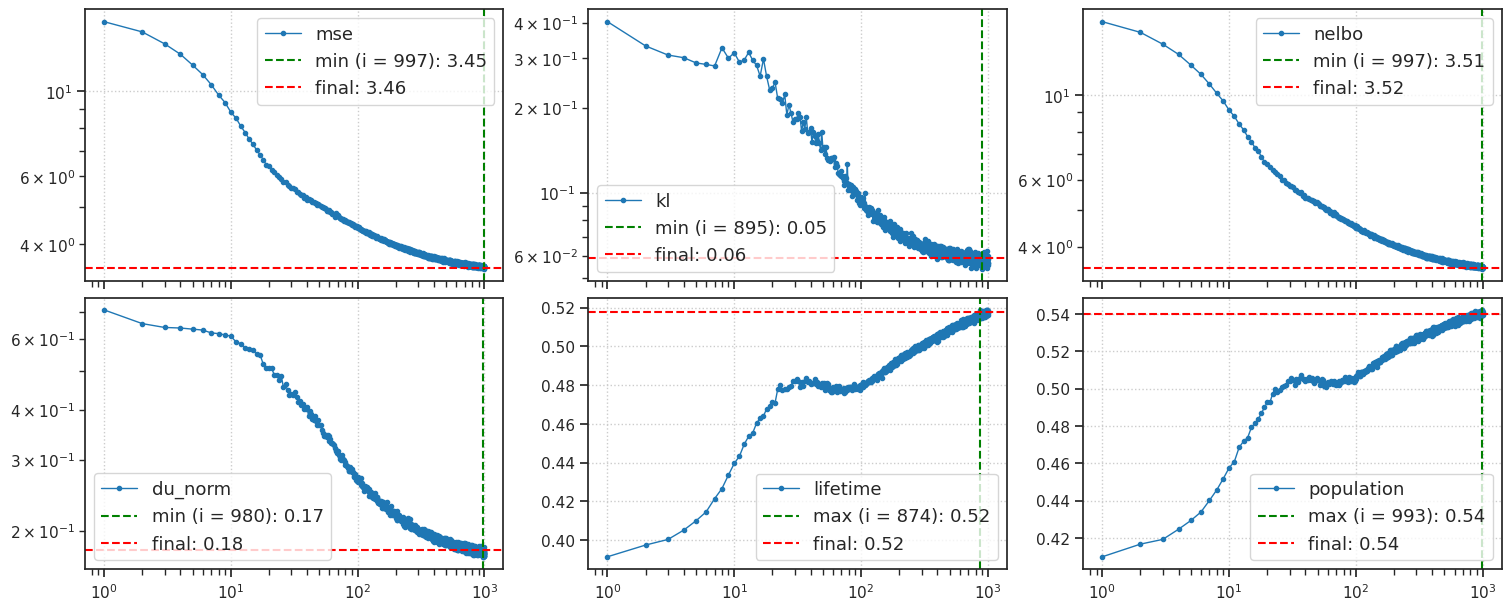

In [15]:
_ = plot_convergence(results_avg)

In [17]:
order = np.argsort(results['mse'][:, -1])

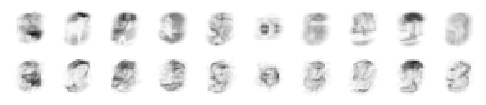

In [31]:
intvl = range(150, 160)

x2p = np.concatenate([
    tonp(vld_cifar.dataset.tensors[0])[order[intvl]],
    tonp(recon)[order[intvl]],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=60, cmap='Greys', vmin=0.05, vmax=1.0)

In [18]:
results['mse'][:, -1][order[:10]]

array([1.189036 , 1.2494841, 1.2908803, 1.3980129, 1.4471245, 1.5019813,
       1.5642905, 1.5686917, 1.5853866, 1.6407187], dtype=float32)

In [32]:
selected_inds = order[100:110]
x_selected = vld_down.dataset.tensors[0][selected_inds]

results_selected = tr.analysis(
    dl=torch.utils.data.TensorDataset(x_selected),
    seq_total=1_000,
    n_data_batches=None,
    return_recon=True,
    avg_samples=False,
)
list(results_selected)

100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


['kl',
 'mse',
 'nelbo',
 'du_norm',
 'lifetime',
 'population',
 'state_final',
 'samples_final',
 'recon']

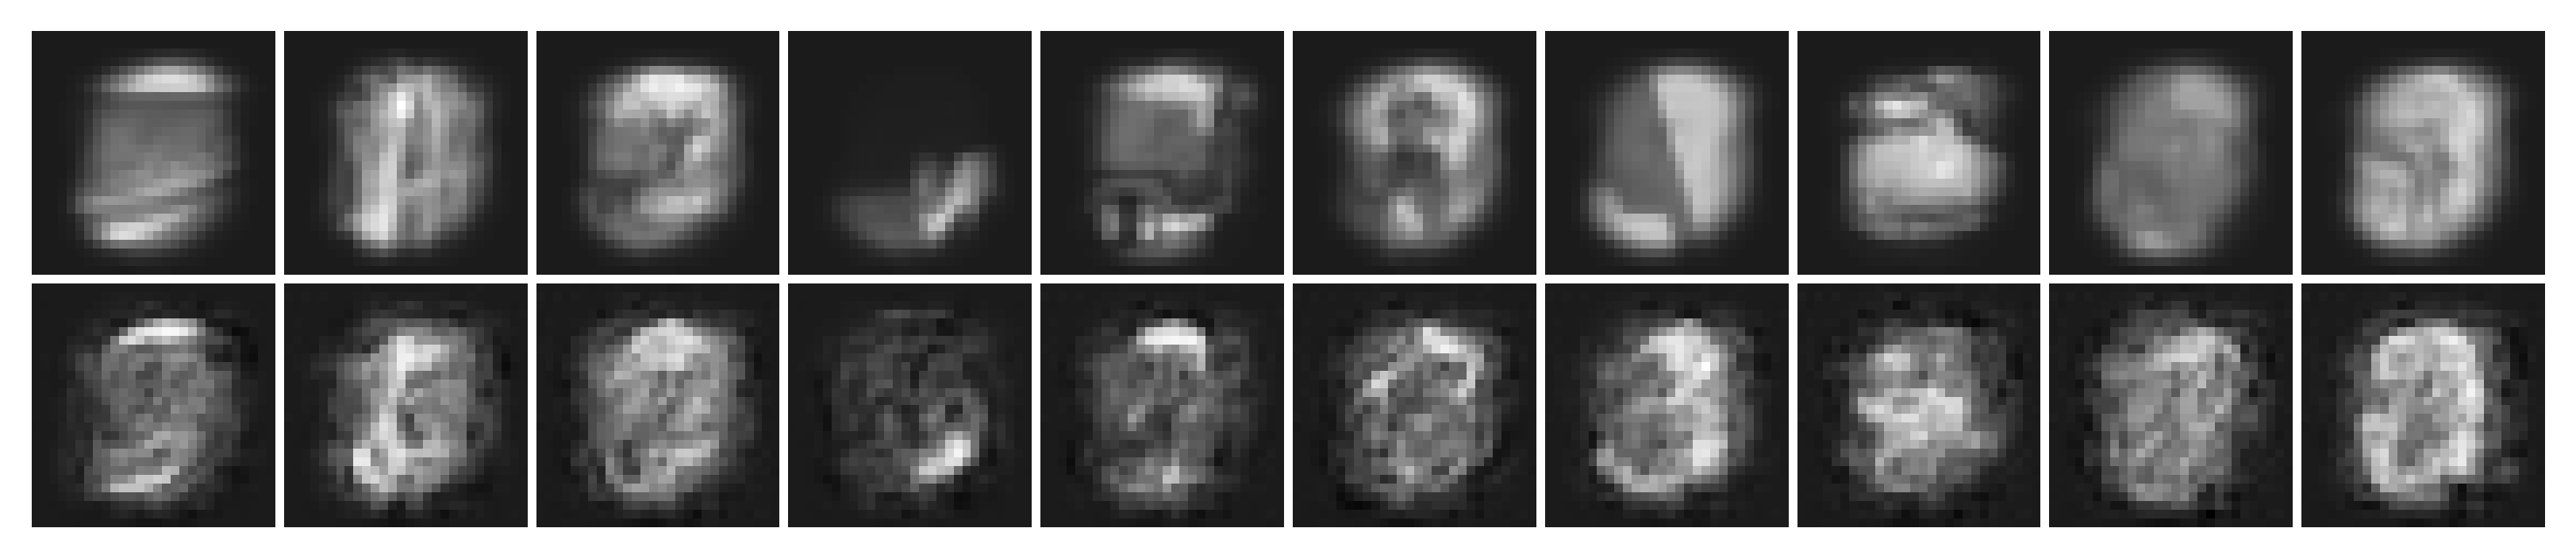

In [38]:
var_cifar = torch.var(vld_down.dataset.tensors[0], dim=(1, 2, 3))
order_var = np.argsort(tonp(var_cifar))[::-1]

In [39]:
order_var

array([3444, 1256, 4072, ..., 5578, 4032, 7415])

In [43]:
selected_inds = order_var[:2000]
x_selected = tonp(vld_down.dataset.tensors[0])[selected_inds]
x_selected = tr.to(x_selected)

results_selected = tr.analysis(
    dl=torch.utils.data.TensorDataset(x_selected),
    seq_total=1_000,
    n_data_batches=None,
    return_recon=True,
    avg_samples=False,
)
list(results_selected)

100%|█████████████████████████████████| 10/10 [00:36<00:00,  3.69s/it]


['kl',
 'mse',
 'nelbo',
 'du_norm',
 'lifetime',
 'population',
 'state_final',
 'samples_final',
 'recon']

In [16]:
num = 12



x2p = np.concatenate([
    tonp(x_selected)[-num:],
    recon[-num:],
])
fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=400)

NameError: name 'results_selected' is not defined

In [47]:
tr = trainers['MNIST_<jacob|mlp>_(64,24.0)']

results = tr.analysis(
    dl=vld_down,
    seq_total=1_000,
    n_data_batches=3,
    return_recon=True,
    avg_samples=False,
)

100%|███████████████████████████████████| 3/3 [00:11<00:00,  3.77s/it]


In [61]:
recon = tr.to(results['recon'][:, -1]).reshape(tr.model.cfg.shape)
src = vld_down.dataset.tensors[0][:len(recon)]

In [64]:
def mse(source, reconstructed):
    return torch.mean((source - reconstructed) ** 2, dim=[1, 2, 3])

def image_variance(source):
    return torch.var(source, dim=[1, 2, 3])

def normalized_mse(source, reconstructed):
    mse_value = mse(source, reconstructed)
    variance_value = image_variance(source)
    return mse_value / variance_value

<Axes: ylabel='Count'>

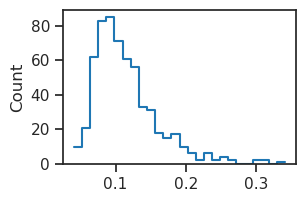

In [66]:
nmse = normalized_mse(src, recon)
histplot(tonp(nmse))

In [111]:
order = np.argsort(tonp(nmse))[180:]

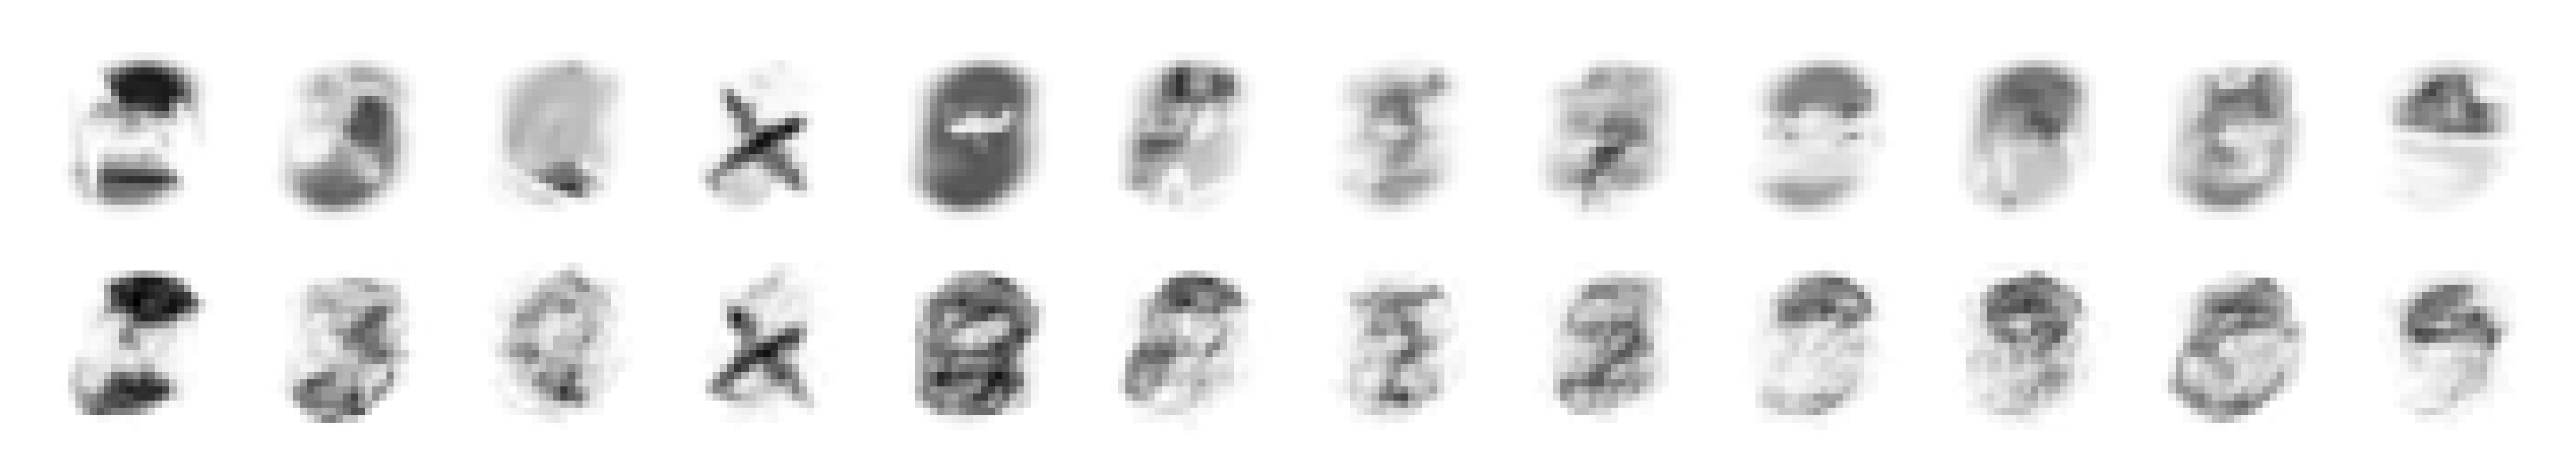

In [152]:
from analysis.clf import LogisticRegression

In [153]:
accuracy, results = ood_analysis(tr, trn.dataset, vld.dataset, t_recon=1000)

In [154]:
accuracy

0.3103

In [ ]:
for i in range(len(results['mse']) // 10):
    intvl = range(i * 10, (i + 1) * 10)

    recon = results['recon'][:, -1]
    recon = recon.reshape(tr.model.cfg.shape)
    
    x2p = np.concatenate([
        tonp(vld_down.dataset.tensors[0])[order[intvl]],
        recon[order[intvl]],
    ])
    fig, ax = plot_weights(x2p, nrows=2, method='none', dpi=400)

    name = str(intvl).replace(' ', '')
    name = f"{name}.png"
    fig.savefig(pjoin(fig_base_dir, 'iclr_oct02/mnist_to_cifar', name), **kws_fig)

In [ ]:
tr = trainers['Omniglot_<jacob|conv>_(16,8.0)']

results = tr.analysis(
    dl=vld_down,
    seq_total=10_000,
    n_data_batches=10,
    return_recon=True,
)

In [ ]:
_ = plot_convergence(results)

In [ ]:
num = 10

recon = results['recon'][:, -1]
recon = recon.reshape(tr.model.cfg.shape)

x2p = np.concatenate([
    tonp(vld_down.dataset.tensors[0])[:num],
    recon[:num],
])
plot_weights(x2p, nrows=2, method='none');